## Example Usage for the ndx-patterne-ogen-stimulation on Abdeladim2023 dataset
In the following tutorial, we demonstrate use of the `ndx-patterned-ogen` extension to the NWB data standard. Specifically we:
1. Create `SpatialLightModulator` and `LightSource` containers, representing the devices used in the paradigm.
2. Use the `PatternedOptogeneticStimulusSite` container to store information about location, the opsin and excitation wavelength used in the paradigm
3. Use the `TemporalFocusing` container to store the pattern-specific parameters of the stimulus onset.
4. Record the stimulus presentation within the `PatternedOptogeneticStimulusTable` container
6. Write all devices, stimuli, and presentation tables to an `.nwb` file and confirm it can be read back

First, we import then necessary files and create an empty `NWBFile`.

In [1]:
import datetime
import numpy as np
from pathlib import Path
from natsort import natsorted
import h5py
import matplotlib.pyplot as plt


from pynwb import NWBFile, NWBHDF5IO
from pynwb.ophys import PlaneSegmentation, OpticalChannel
from ndx_patterned_ogen import (
    SpatialLightModulator2D,
    LightSource,
    PatternedOptogeneticStimulusSite,
    PatternedOptogeneticStimulusTable,
    OptogeneticStimulusTarget,
    TemporalFocusing,
)
from roiextractors.extractors.tiffimagingextractors.scanimagetiff_utils import (
    extract_extra_metadata,
    extract_rois_metadata,
)

root_path = Path(f"/media/amtra/Samsung_T5/CN_data")
assert root_path.is_dir()
folder_path = root_path / "MouseV1-to-nwb"
assert folder_path.is_dir()
epochs_name = ["2ret", "3ori", "4ori", "5stim", "6stim", "7expt"]
epoch_index = 3
session_id = epochs_name[epoch_index]
channel_name = "chan1"

# Extract holographic data of the session
imaging_path = folder_path / "raw-tiffs" / session_id
imaging_path = Path(imaging_path)
stim_file = folder_path / "example_data.hdf5"
stim_data = h5py.File(stim_file, "r")
stim_data = stim_data[session_id]

nwbfile = NWBFile(
    session_description="patterned optogenetic synthetic experiment (all optical system)",
    identifier="identifier",
    session_start_time=datetime.datetime.now(datetime.timezone.utc),
)

## Spatial light modulator and Light source

We begin by creating all the devices needed in this stimulation paradigm: `SpatialLightModulator` , `LightSource` and a microscope 

In [2]:
# metadata for spiatial light modulator
spatial_light_modulator = SpatialLightModulator2D(
    name="SpatialLightModulator",
    description="Generic description for the slm",
    model="slm model",
    manufacturer="slm manufacturer",
    spatial_resolution=[512, 512],
)
nwbfile.add_device(spatial_light_modulator)

# metadata for the light source
light_source = LightSource(
    name="Laser",
    model="laser model",
    manufacturer="laser manufacturer",
    stimulation_wavelength=600.0,  # nm
    description="Generic description for the laser",
    peak_power=70e-3,  # the peak power of stimulation in Watts
    intensity=0.005,  # the intensity of excitation in W/mm^2
    exposure_time=2.51e-13,  # the exposure time of the sample in seconds
    pulse_rate=1 / 2.51e-13,  # the pulse rate of the laser is in Hz
)
nwbfile.add_device(light_source)

# metadata for the microscope
microscope = nwbfile.create_device(
    name="2P_microscope",
    description="My two-photon microscope",
    manufacturer="The best microscope manufacturer",
)

# Optogenetic stimulus site

Store the information about the location, the opsin and excitation wavelength used in the paradigm 

In [3]:
# metadata for the stimulus methods
site = PatternedOptogeneticStimulusSite(
    name="PatternedOptogeneticStimulusSite",
    description="Scanning",  # Scanning or scanless method for shaping optogenetic light (e.g., diffraction limited points, 3D shot, disks, etc.).
    excitation_lambda=600.0,  # nm
    effector="ChR2",
    location="VISrl",
    device=microscope,
    spatial_light_modulator=spatial_light_modulator,
    light_source=light_source,
)
nwbfile.add_ogen_site(site)

PatternedOptogeneticStimulusSite ndx_patterned_ogen.patterned_ogen.PatternedOptogeneticStimulusSite at 0x139727841713968
Fields:
  description: Scanning
  device: 2P_microscope pynwb.device.Device at 0x139727841721744
Fields:
  description: My two-photon microscope
  manufacturer: The best microscope manufacturer

  effector: ChR2
  excitation_lambda: 600.0
  light_source: Laser ndx_patterned_ogen.patterned_ogen.LightSource at 0x139727841721840
Fields:
  description: Generic description for the laser
  exposure_time: 2.51e-13
  intensity: 0.005
  manufacturer: laser manufacturer
  model: laser model
  peak_power: 0.07
  pulse_rate: 3984063745019.9204
  stimulation_wavelength: 600.0

  location: VISrl
  spatial_light_modulator: SpatialLightModulator ndx_patterned_ogen.patterned_ogen.SpatialLightModulator2D at 0x139727841711904
Fields:
  description: Generic description for the slm
  manufacturer: slm manufacturer
  model: slm model
  spatial_resolution: [512 512]

## Define the stimulus pattern applied during the photostimulation

In [4]:
# metadata for temporal focusing pattern
temporal_focusing = TemporalFocusing(
    name="TemporalFocusing",
    description="scanless beam pattern",
    lateral_point_spread_function="9 um ± 0.7 um",
    axial_point_spread_function="32 um ± 1.6 um",
)
nwbfile.add_lab_meta_data(temporal_focusing)

TemporalFocusing ndx_patterned_ogen.patterned_ogen.TemporalFocusing at 0x139727841721696
Fields:
  axial_point_spread_function: 32 um ± 1.6 um
  description: scanless beam pattern
  lateral_point_spread_function: 9 um ± 0.7 um

## Imaging Plane and Optical Channel definition

Define a `PlaneSegmentation` to link the photostimulation to the sets of stimulated ROIs (holograms).
To do so, we need to define an `ImagingPlane` and an `OpticalChannel` first.


In [5]:
optical_channel = OpticalChannel(
    name="OpticalChannel",
    description="an optical channel",
    emission_lambda=500.0,
)
imaging_plane_name = "ImagingPlane"
imaging_plane = nwbfile.create_imaging_plane(
    name=imaging_plane_name,
    optical_channel=optical_channel,
    description="a very interesting part of the brain",
    device=microscope,
    excitation_lambda=600.0,
    indicator="GFP",
    location="V1",
)

# Targeted rois centroids
All the ROIs simulataneously illuminated are stored in `targeted_rois` in an `OptogeneticStimulusTarget` container, as a list of centroids in pixel.

In [6]:
import scipy.io

mat_file_path = folder_path / "raw-tiffs/makeMasks3D_img.mat"
mat_data = scipy.io.loadmat(mat_file_path)
imgData = mat_data["imgData"]
backgorund = imgData[:, :, 0]+imgData[:, :, 1]+imgData[:, :, 2]

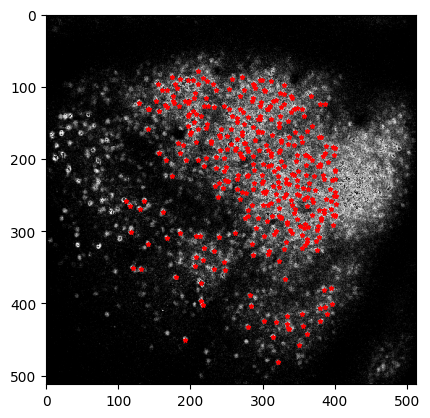

In [7]:
tif_files = natsorted(imaging_path.glob("*.tif"))
rois_metadata = extract_rois_metadata(tif_files[0])
pixel_to_space = np.array(rois_metadata["imagingRoiGroup"]["rois"]["scanfields"]["pixelToRefTransform"])
space_to_pixel = np.linalg.inv(pixel_to_space)

rois_metadata = rois_metadata["integrationRoiGroup"]["rois"]
targeted_rois = []

targeted_plane_segmentation = PlaneSegmentation(
    name="TargetedPlaneSegmentation",
    description="Targeted ROIs from the ScanImage metadata",
    imaging_plane=imaging_plane,
)

plt.imshow(backgorund,cmap="grey")
for roi in rois_metadata:
    X = roi["scanfields"]["centerXY"][0]
    Y = roi["scanfields"]["centerXY"][1]
    Z = 1
    spatial_coordinates_roi_centroid = np.array([X,Y,Z])
    pixel_coordinates_roi_centroid = space_to_pixel @ spatial_coordinates_roi_centroid
    pixel_coordinates_roi_centroid = np.round(pixel_coordinates_roi_centroid).astype(int)
    plt.scatter(pixel_coordinates_roi_centroid[:][0],pixel_coordinates_roi_centroid[:][1],s=9,c="red",marker='*')
    targeted_plane_segmentation.add_roi(pixel_mask=[pixel_coordinates_roi_centroid])
    
plt.xlim(0,512)
plt.ylim(0,512)
plt.gca().invert_yaxis()
plt.show()



## Plane segmentation containing information of stimulated ROIs 
Then, we define a `PlaneSegmentation` containing ... TODO

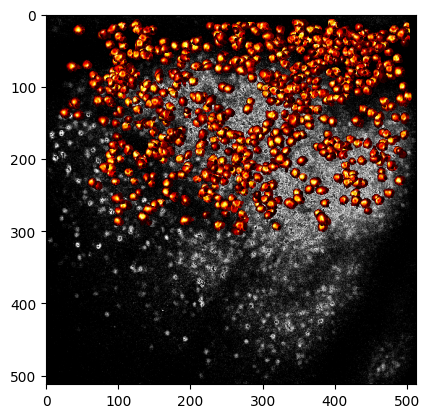

In [8]:
# create a plane segmentation to store
plane_segmentation = PlaneSegmentation(
    name="PlaneSegmentationHolographicStimulation",
    description="only accepted ROIs from the three plane segmentation concatenated",
    imaging_plane=imaging_plane,
)
  
# we need to concatenate the 3 suite2p plane segmentations but keep only the accepted ROIs+
# then add an extra column that would save the corresponding targeted rois centroids
from roiextractors.extractors.suite2p.suite2psegmentationextractor import Suite2pSegmentationExtractor

segmentation_path = folder_path / "processed-suite2p-data/suite2p"
available_planes = Suite2pSegmentationExtractor.get_available_planes(folder_path=segmentation_path)
# %% MAP targeted ROIs in the respective segmented rois (from Suite2p Segmentation)
targeted_to_stim_map = stim_data["targeted_cells"]


plt.imshow(backgorund,cmap='gray')
for plane_name in available_planes:
    segmentation_extractor = Suite2pSegmentationExtractor(
        folder_path=segmentation_path, channel_name=channel_name, plane_name=plane_name
    )
    accepted_rois = segmentation_extractor.get_accepted_list()
    accepted_roi_masks = segmentation_extractor.get_roi_pixel_masks(accepted_rois)
    segmented_roi_centroids = segmentation_extractor.roi_locations

    for roi_mask in accepted_roi_masks:
        plane_segmentation.add_roi(pixel_mask=roi_mask)
        x_coords, y_coords, weights = zip(*roi_mask)
        plt.scatter(x_coords,y_coords,c=weights, cmap='hot', s=1)

plt.xlim(0,512)
plt.ylim(0,512)
plt.gca().invert_yaxis()
plt.show()

In [9]:
len(targeted_to_stim_map[np.isnan(targeted_to_stim_map)])

193

In [10]:
# TODO global_id
targeted_not_stimulated_rois = targeted_to_stim_map[np.isnan(targeted_to_stim_map)]
segmented_to_glob_ids = np.array(plane_segmentation[:].index)
targeted_to_glob_ids = np.zeros((len(targeted_to_stim_map)))
targeted_to_glob_ids[np.isnan(targeted_to_stim_map)] = np.arange(len(segmented_to_glob_ids), len(segmented_to_glob_ids) + len(targeted_not_stimulated_rois))
targeted_to_glob_ids[~np.isnan(targeted_to_stim_map)] = targeted_to_stim_map[~np.isnan(targeted_to_stim_map)]

In [11]:
plane_segmentation.add_column(
    name="global_ids", description="Global roi ids to match targeted ROIs",data=segmented_to_glob_ids
)
targeted_plane_segmentation.add_column(
    name="global_ids", description="ROI IDs of the targeted and segmented ROIs",data=targeted_to_glob_ids.astype(int)
)

In [12]:
if nwbfile is not None:
    if "ophys" not in nwbfile.processing:
        nwbfile.create_processing_module("ophys", "ophys")
    nwbfile.processing["ophys"].add(plane_segmentation)
    nwbfile.processing["ophys"].add(targeted_plane_segmentation)

KeyError: "'ImageSegmentation' not found in ProcessingModule 'ophys'."

## Define photostimulation table 

Define the stimulus sequences on the targeted ROIs previously defined in the imaging frame coordinates ... TODO


In [ ]:
stimulus_table = PatternedOptogeneticStimulusTable(
    name="PatternedOptogeneticStimulusTable", description="Patterned stimulus"
)
hologram_list = stim_data["hologram_list"]
for trial, hologram_index in enumerate(stim_data["stim_id"]):
    # 7expt has incomplete data
    if trial>=len(tif_files):
        break
    # CREATE HOLOGRAM from hologram list
    if hologram_index != 0:  #
        hologram_index = hologram_index-1
        roi_group = hologram_list[hologram_index]
        roi_indexes = roi_group[~np.isnan(roi_group)].astype(int)
        if len(roi_indexes) > 0:
            segmented_rois = plane_segmentation.create_roi_table_region(
                name="segmented_rois",
                description="segmented rois that have been stimulated",
                region=list(roi_indexes),
            )
            # targeted_rois = targeted_rois[roi_group] # se puntassero a indice
            targeted_rois = targeted_plane_segmentation.create_roi_table_region(
                name="targeted_rois",
                description="targeted rois",
                # region=list(plane_segmentation["targeted_rois_ids"][roi_indexes]),
                region=[i for i,roi_index in enumerate(targeted_to_stim_map) if roi_index in roi_indexes],
            )
            hologram_name = f"Hologram{hologram_index}"
            hologram = OptogeneticStimulusTarget(
                name=hologram_name, segmented_rois=segmented_rois, targeted_rois=targeted_rois
            )
            if hologram_name not in nwbfile.lab_meta_data:
                nwbfile.add_lab_meta_data(hologram)
            image_metadata = extract_extra_metadata(file_path=tif_files[trial])
            trial_start_time = float(image_metadata["frameTimestamps_sec"])
            power = stim_data["power_per_cell"][trial]
            frequency = stim_data["hz_per_cell"][trial]
            n_spike = stim_data["spikes_per_cell"][trial]
            stimulus_time = stim_data["stim_times"][np.where(targeted_to_stim_map==roi_indexes[0])[0]]
            start_time = trial_start_time + stimulus_time[0]
            stop_time = start_time + np.round(n_spike / frequency, decimals=2)
            if ~np.isnan(start_time):
                stimulus_table.add_interval(
                    start_time=start_time,
                    stop_time=stop_time,
                    power=power,
                    frequency=frequency,
                    stimulus_pattern=temporal_focusing,
                    targets=nwbfile.lab_meta_data[hologram_name],
                    stimulus_site=site,
                )
nwbfile.add_time_intervals(stimulus_table)

In [ ]:
targeted_plane_segmentation[:]

Write and read the NWB File

In [ ]:
nwbfile_path = root_path / "MouseV1-conversion_nwb/holo_stim.nwb"
with NWBHDF5IO(nwbfile_path, mode="w") as io:
    io.write(nwbfile)

with NWBHDF5IO(nwbfile_path, mode="r") as io:
    nwbfile_in = io.read()